# ASSIGNMENT-0 
Graph Mining                          Dr. Pawel Pralat

In [1]:
## path to datasets
datadir='../Datasets/'

In [2]:
import igraph as ig
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import plfit
from sklearn.linear_model import LinearRegression
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF as ecdf

# Problem-1
Perform a similar type of EDA as in Section 1.12 (in particular,
regenerate Table 1.1) on the 1,000 node ABCD graph. Data (edge
list) can be found in Datasets/ABCD/abcd 1000.dat on the GitHub
repo.

In [3]:
## read the abcd_1000 edge list into a graph
gr = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_1000.dat', directed=False)
gr = gr.simplify()

In [5]:
## basic stats in a table
S=[]
deg = gr.degree()
S.append(['ABCD',gr.vcount(),gr.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.quantile(deg,.99),
      np.max(deg),gr.diameter(),np.max(gr.clusters().membership)+1,gr.clusters().giant().vcount(),
         sum([x==0 for x in gr.degree()]),gr.transitivity_undirected(),gr.transitivity_avglocal_undirected()])


In [6]:
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',r'$d_{median}$',
                            r'$d_{quant_{99}}$',r'$d_{max}$','diameter','components','largest',
                            'isolates',r'$C_{glob}$',r'$C_{loc}$'])
D = D.transpose()
D

,0
graph,ABCD
nodes,1000
edges,8327
$d_{min}$,9
$d_{mean}$,16.654
$d_{median}$,13
$d_{quant_{99}}$,62.01
$d_{max}$,92
diameter,4
components,1


# Problem-2
The link 1 to the Grid network (Europe) has also data for North
America. Perform a similar type of EDA as in Section 1.12 (in
particular, regenerate Table 1.1) for that graph, including getting
and preparing the data which is usually the most time consuming
part of the process. The raw downloaded files can be also found in
Datasets/GridNorthAmerica on the GitHub repo. You can look at
the raw files and the processed data in Datasets/GridEurope and
do the same for North America.

In [10]:
## read edge list for the grid network
gr = pd.read_csv(datadir+'GridNorthAmerica/gridkit_north_america-highvoltage-links.csv')
tuples = [tuple(x) for x in gr.values]
gr = ig.Graph.TupleList(tuples, directed = False)

## read the vertices along with some attributes
X = pd.read_csv(datadir+'GridNorthAmerica/gridkit_north_america-highvoltage-vertices.csv')
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()]
gr.vs['size'] = 3
gr.es['color'] = 'grey'
gr.vs['color'] = 'black'

In [13]:
S=[]
deg = gr.degree()
S.append(['Grid_NA',gr.vcount(),gr.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.quantile(deg,.99),
      np.max(deg),gr.diameter(),np.max(gr.clusters().membership)+1,gr.clusters().giant().vcount(),
         sum([x==0 for x in gr.degree()]),gr.transitivity_undirected(),gr.transitivity_avglocal_undirected()])

In [14]:
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',r'$d_{median}$',
                            r'$d_{quant_{99}}$',r'$d_{max}$','diameter','components','largest',
                            'isolates',r'$C_{glob}$',r'$C_{loc}$'])
D = D.transpose()
D

,0
graph,Grid_NA
nodes,28305
edges,22459
$d_{min}$,1
$d_{mean}$,1.58693
$d_{median}$,1
$d_{quant_{99}}$,6
$d_{max}$,25
diameter,18
components,5846


# Problem-3
In the original GitHub graph on 37,700 nodes,

a.find the number of walks of length 5;
b.find the number of cycles of length 4 (induced, that is, without
chords).

In [33]:
## read the GitHub edge list into a graph
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## add some node features, here there are
## 2 class of nodes, 0: web developer (red), 1: ml developer (blue)
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gh.vs['target'] = list(X['ml_target'])
cls = ['grey','black']
lbl = ['web','ml']
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]
gh.es['color'] = 'grey'

In [32]:

def count_paths(v, n, a):
    # v: number of vertices, n: expected path length
    paths = 0    
    b = np.array(a, copy=True)

    for i in range(n-2):
        b = np.dot(b, a)

    c = np.dot(b, a)
    x = c - b

    for i in range(v):
        for j in range(i+1, v):
            if x[i][j] == 1:
                paths = paths + 1

    return paths

print(count_paths(289003, 5, tuples))


ValueError: shapes (289003,2) and (289003,2) not aligned: 2 (dim 1) != 289003 (dim 0)

2476

# Problem-4
Consider the airport graph available in
Datasets/Airport/airport data.csv on the GitHub repo (the
first 3 fields are respectively origin, destination, and number of pas-
sengers). This graph is weighted and directed; weight of a directed
edge uv corresponds to the number of passengers traveling from
airport u to airport v.

In [19]:
## define the colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

In [20]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/airport_data.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
df = D.head()

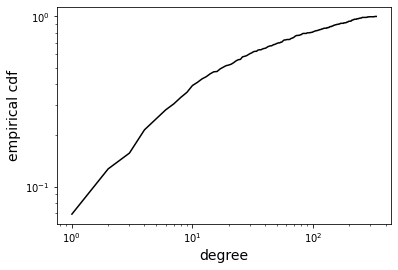

In [21]:
## cumulative degree distribution (points (`l, n ≥l` ), where
deg = g.degree()
e = ecdf(deg)
x = np.arange(1,max(deg),1)
y = [e(i) for i in x]
plt.loglog(x,y,'-',color='black',label='Airport')
plt.xlabel('degree',fontsize=14)
plt.ylabel('empirical cdf',fontsize=14);
#plt.savefig('ecdf_gh.eps');

In [22]:
# read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
df = D.head()

In [23]:
# read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
## add a few more attributes for visualization
g.vs()['size'] = sz[1]
g.vs()['color'] = cls[1]
g.es()['color'] = cls_edges
g.es()['arrow_size'] = 0.33
df = A.head()

In [24]:
## Build smaller subgraph for California 
hva = [v for v in g.vs() if v['state'] == 'CA']
G = g.subgraph(hva)

## remove loops
G = G.simplify(multiple=False)
print(G.vcount(),'nodes and',G.ecount(),'directed edges')

## counting isolated vertices (i.e. without in-state connections)
I= G.subgraph([v for v in G.vs() if v.degree()<=0])
print(I.vcount(),'isolated nodes')

31 nodes and 134 directed edges
9 isolated nodes


# Problem-5
Take 100 random pairs of nodes in the European Grid network.
For each pair plot a point (x, y), where x is the graph distance
between the two nodes and y is the corresponding geographical
distance (in kilometres). Is there a correlation between the two dis-
tances?

In [25]:
## read edge list for the grid network
gr = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
gr = gr.simplify()

## read the vertices along with some attributes
X = pd.read_csv(datadir+'GridEurope/gridkit_europe-highvoltage.vertices')
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()]
gr.vs['size'] = 3
gr.es['color'] = 'grey'
gr.vs['color'] = 'black'

In [26]:
sg = gr.clusters().giant()
V = np.random.choice(sg.vcount(),size=100,replace=False) ## sample